In [33]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns
import pandas as pd

from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
from skimage.feature import hog, local_binary_pattern

# Rock-Paper-Scissors Classification

## Overview
This notebook implements a hand gesture classification system using:
1. **RootSIFT** - Enhanced SIFT descriptor with L1 normalization and square root transformation
2. **Bag of Visual Words (BoVW)** - Feature encoding using K-Means clustering
3. **Support Vector Classifier (SVC)** - Multi-class classification

## Classes
- Rock, Paper, Scissors, Background

In [34]:
DATA_PATH = 'dataset'
CLASSES = ['rock', 'scissors', 'paper', 'background']
NUM_CLASSES = len(CLASSES)

N_CLUSTERS = 200
MAX_FEATURES = 500
TEST_SIZE = 0.2
RANDOM_STATE = 67

## 1. Define descriptors

In [35]:
class RootSIFT:
    def __init__(self, sift=None):
        self.sift = sift

    def detectAndCompute(self, image, param):
        keypoints, descriptors = self.sift.detectAndCompute(image, None)

        if descriptors is None:
            return keypoints, None

        descriptors /= (np.linalg.norm(descriptors, ord=1, axis=1, keepdims=True) + 1e-7)
        descriptors = np.sqrt(descriptors)
        return keypoints, descriptors.astype(np.float32)

class HOGDescriptor:
    def __init__(self, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(2, 2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def compute(self, image):
        features = hog(image, orientations=self.orientations,
                      pixels_per_cell=self.pixels_per_cell,
                      cells_per_block=self.cells_per_block,
                      block_norm='L2-Hys', feature_vector=True)
        return features.astype(np.float32)

class LBPDescriptor:
    def __init__(self, radius=3, n_points=24):
        self.radius = radius
        self.n_points = n_points
    
    def compute(self, image):
        lbp = local_binary_pattern(image, self.n_points, self.radius, method='uniform')
        n_bins = self.n_points + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        return hist.astype(np.float32)

sift = cv2.SIFT_create(nfeatures=MAX_FEATURES)
rootsift = RootSIFT(sift=sift)
akaze = cv2.AKAZE_create()
orb = cv2.ORB_create(nfeatures=MAX_FEATURES)
hog_desc = HOGDescriptor()
lbp_desc = LBPDescriptor()

## 2. Load Dataset

In [36]:
def load_images(folder):
    images = []
    for f in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, f))
        images.append(img)
    return images

images, labels = [], []
for idx, cls in enumerate(CLASSES):
    class_imgs = load_images(os.path.join(DATA_PATH, cls))
    images.extend(class_imgs)
    labels.extend([idx] * len(class_imgs))
    print(f"{cls}: {len(class_imgs)} images")

print(f"\nTotal: {len(images)} images")

rock: 240 images
scissors: 240 images
paper: 240 images
background: 34 images

Total: 754 images


## 3. Preprocess Image + Augmentation

In [37]:
def resize_image(img, target_size=(256, 256)):
    return cv2.resize(img, target_size)

In [38]:
resized_images = []

for img in tqdm(images, desc="Resizing"):
    resized_img = resize_image(img)
    resized_images.append(resized_img)

Resizing: 100%|██████████| 754/754 [02:19<00:00,  5.41it/s] 


In [39]:
def augment_image(img):
    augmented = [img]
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    
    # 1. Horizontal flip
    augmented.append(cv2.flip(img, 1))
    
    # 2. Rotate (-15, +15 )
    for angle in [-15, 15]:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h))
        augmented.append(rotated)
    
    # 3. Brignhtness
    for factor in [0.7, 1.3]:
        adjusted = cv2.convertScaleAbs(img, alpha=factor, beta=0)
        augmented.append(adjusted)
    
    return augmented

In [40]:
# 754 * 6 + 754 = 8294
all_images = []
all_labels = []

for i, img in enumerate(resized_images):
    all_images.append(img)
    all_labels.append(labels[i])
    
    augmented_versions = augment_image(img)
    for aug_img in augmented_versions:
        all_images.append(aug_img)
        all_labels.append(labels[i])

all_images, all_labels = shuffle(all_images, all_labels, random_state=RANDOM_STATE)
print(f"Total after augmentation: {len(all_images)} images")

Total after augmentation: 5278 images


In [41]:
def preprocess_image(img):
    if img is None:
        return None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (3, 3), 0)
    return gray_blur

In [42]:
preprocessed_images = []

for img in tqdm(all_images, desc="Preprocessing"):
    preprocessed_img = preprocess_image(img)
    preprocessed_images.append(preprocessed_img)

print(f"Total preprocessed images: {len(preprocessed_images)}")

Preprocessing: 100%|██████████| 5278/5278 [00:02<00:00, 1955.91it/s]

Total preprocessed images: 5278


In [43]:
len(preprocessed_images)

5278

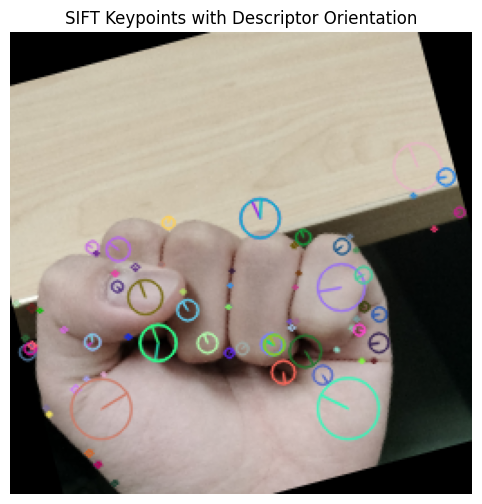

In [44]:
kps, prep = rootsift.detectAndCompute(all_images[0 ], None)

img_test = cv2.drawKeypoints(all_images[0 ], kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints with Descriptor Orientation")
plt.axis('off')
plt.show()

In [45]:
def extract_features(images, descriptor):
  descriptors_list = []

  for img in tqdm(images, desc="Extracting features"):
    _, desc = descriptor.detectAndCompute(img, None)
    descriptors_list.append(desc)
  return descriptors_list

In [46]:
descriptors_list_sift = extract_features(preprocessed_images, sift)
descriptors_list_rootsift = extract_features(preprocessed_images, rootsift)
descriptors_list_akaze = extract_features(preprocessed_images, akaze)
descriptors_list_orb = extract_features(preprocessed_images, orb)

X_hog = np.array([hog_desc.compute(img) for img in tqdm(preprocessed_images, desc="Extracting HOG")])
X_lbp = np.array([lbp_desc.compute(img) for img in tqdm(preprocessed_images, desc="Extracting LBP")])
y_hog = np.array(all_labels)
y_lbp = np.array(all_labels)

all_desc_sift = np.vstack([d for d in descriptors_list_sift if d is not None])
print(f"Total descriptors sift: {len(all_desc_sift)}")

all_desc_rootsift = np.vstack([d for d in descriptors_list_rootsift if d is not None])
print(f"Total descriptors rootsift: {len(all_desc_rootsift)}")

all_desc_akaze = np.vstack([d for d in descriptors_list_akaze if d is not None])
print(f"Total descriptors akaze: {len(all_desc_akaze)}")

all_desc_orb = np.vstack([d for d in descriptors_list_orb if d is not None])
print(f"Total descriptors orb: {len(all_desc_orb)}")

print(f"HOG feature shape: {X_hog.shape}")
print(f"LBP feature shape: {X_lbp.shape}")

Extracting LBP: 100%|██████████| 5278/5278 [03:37<00:00, 24.26it/s]


Total descriptors sift: 258016
Total descriptors rootsift: 258016
Total descriptors akaze: 120807
Total descriptors orb: 386072
HOG feature shape: (5278, 1764)
LBP feature shape: (5278, 26)


In [47]:
kmeans_sift = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, batch_size=1000)
kmeans_sift.fit(all_desc_sift)

kmeans_rootsift = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, batch_size=1000)
kmeans_rootsift.fit(all_desc_rootsift)

kmeans_akaze = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, batch_size=1000)
kmeans_akaze.fit(all_desc_akaze)

kmeans_orb = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, batch_size=1000)
kmeans_orb.fit(all_desc_orb)

print(f"Vocabulary built with {N_CLUSTERS} visual words")

Vocabulary built with 200 visual words


In [48]:
def create_histogram(descriptors, kmeans, n_clusters):
    if descriptors is None:
        return np.zeros(n_clusters)
    words = kmeans.predict(descriptors)
    hist, _ = np.histogram(words, bins=range(n_clusters + 1))
    return hist / (np.linalg.norm(hist) + 1e-7)

In [49]:
X_sift = np.array([create_histogram(d, kmeans_sift, N_CLUSTERS) for d in tqdm(descriptors_list_sift, desc="Creating sift histograms")])
y_sift = np.array(all_labels) 

X_rootsift = np.array([create_histogram(d, kmeans_rootsift, N_CLUSTERS) for d in tqdm(descriptors_list_rootsift, desc="Creating rootsift histograms")])
y_rootsift = np.array(all_labels) 

X_akaze = np.array([create_histogram(d, kmeans_akaze, N_CLUSTERS) for d in tqdm(descriptors_list_akaze, desc="Creating akaze histograms")])
y_akaze = np.array(all_labels)  

X_orb = np.array([create_histogram(d, kmeans_orb, N_CLUSTERS) for d in tqdm(descriptors_list_orb, desc="Creating orb histograms")])
y_orb = np.array(all_labels)  

print(f"Feature matrix shape: {X_sift.shape}")
print(f"Labels shape: {y_sift.shape}")

Creating orb histograms: 100%|██████████| 5278/5278 [00:03<00:00, 1605.52it/s]

Feature matrix shape: (5278, 200)
Labels shape: (5278,)


## 6. Cross-Validation Training with Sample Size Analysis

### Configuration
- **K-Fold Cross-Validation**: 5 folds
- **Sample Sizes per Class**: 1, 5, 10, 20, 50, 100, full dataset
- **Evaluation Metric**: Accuracy

In [50]:
K_FOLDS = 5
SAMPLE_SIZES = [5, 10, 20, 50, 100, 200, 400, 800, 'full']

DESCRIPTORS = {
    'SIFT': {'X': X_sift, 'y': y_sift, 'kmeans': kmeans_sift, 'descriptor': sift},
    'RootSIFT': {'X': X_rootsift, 'y': y_rootsift, 'kmeans': kmeans_rootsift, 'descriptor': rootsift},
    'AKAZE': {'X': X_akaze, 'y': y_akaze, 'kmeans': kmeans_akaze, 'descriptor': akaze},
    'ORB': {'X': X_orb, 'y': y_orb, 'kmeans': kmeans_orb, 'descriptor': orb},
    'HOG': {'X': X_hog, 'y': y_hog, 'kmeans': None, 'descriptor': hog_desc},
    'LBP': {'X': X_lbp, 'y': y_lbp, 'kmeans': None, 'descriptor': lbp_desc},
}

print(f"Cross-Validation Configuration:")
print(f"  K-Folds: {K_FOLDS}")
print(f"  Sample Sizes: {SAMPLE_SIZES}")
print(f"  Descriptors: {list(DESCRIPTORS.keys())}")

Cross-Validation Configuration:
  K-Folds: 5
  Sample Sizes: [5, 10, 20, 50, 100, 200, 400, 800, 'full']
  Descriptors: ['SIFT', 'RootSIFT', 'AKAZE', 'ORB', 'HOG', 'LBP']


In [51]:
def sample_data_per_class(X, y, n_samples_per_class, random_state=42):
    np.random.seed(random_state)
    
    if n_samples_per_class == 'full':
        return X, y
    
    sampled_indices = []
    unique_classes = np.unique(y)
    
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        n_available = len(cls_indices)
        n_to_sample = min(n_samples_per_class, n_available)
        
        if n_to_sample > 0:
            selected = np.random.choice(cls_indices, size=n_to_sample, replace=False)
            sampled_indices.extend(selected)
    
    sampled_indices = np.array(sampled_indices)
    np.random.shuffle(sampled_indices)
    
    return X[sampled_indices], y[sampled_indices]


def train_svm_model(X_train, y_train):
    svc = SVC(kernel='rbf', C=10.0, gamma='scale', probability=True, 
              class_weight='balanced', random_state=RANDOM_STATE)
    svc.fit(X_train, y_train)
    return svc


def cross_validate_with_sampling(X, y, n_samples_per_class, k_folds=5, random_state=42):
    X_sampled, y_sampled = sample_data_per_class(X, y, n_samples_per_class, random_state)
    
    unique_classes, class_counts = np.unique(y_sampled, return_counts=True)
    min_class_count = class_counts.min()
    total_samples = len(y_sampled)
    
    if min_class_count < 2:
        model = train_svm_model(X_sampled, y_sampled)
        
        np.random.seed(random_state)
        all_indices = np.arange(len(y))
        sampled_set = set(np.where(np.isin(y, y_sampled))[0][:len(y_sampled)])
        
        eval_size = max(100, int(0.2 * len(y)))
        eval_indices = np.random.choice(len(y), size=min(eval_size, len(y)), replace=False)
        
        X_eval, y_eval = X[eval_indices], y[eval_indices]
        y_pred = model.predict(X_eval)
        accuracy = accuracy_score(y_eval, y_pred)
        
        return [accuracy], model
    
    effective_k_folds = min(k_folds, min_class_count)
    
    if effective_k_folds < 2:
        effective_k_folds = 2
    
    skf = StratifiedKFold(n_splits=effective_k_folds, shuffle=True, random_state=random_state)
    
    fold_accuracies = []
    best_model = None
    best_accuracy = 0.0
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_sampled, y_sampled)):
        X_train, X_val = X_sampled[train_idx], X_sampled[val_idx]
        y_train, y_val = y_sampled[train_idx], y_sampled[val_idx]
        
        model = train_svm_model(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    return fold_accuracies, best_model


print("Sampling and cross-validation functions defined.")

Sampling and cross-validation functions defined.


In [52]:
results = defaultdict(lambda: defaultdict(dict))
best_models = defaultdict(dict)

for desc_name, desc_data in DESCRIPTORS.items():
    print("\n")
    print("=" * 30)
    print(f"Descriptor: {desc_name}\n")
    
    X = desc_data['X']
    y = desc_data['y']
    
    for sample_size in SAMPLE_SIZES:
        sample_label = sample_size if sample_size != 'full' else f"full ({len(y)//NUM_CLASSES})"
        print(f"\n Sample size per class: {sample_label}")
        
        fold_accuracies, best_model = cross_validate_with_sampling(
            X, y, sample_size, k_folds=K_FOLDS, random_state=RANDOM_STATE
        )
        
        mean_acc = np.mean(fold_accuracies)
        std_acc = np.std(fold_accuracies)
        
        results[desc_name][sample_size] = {
            'fold_accuracies': fold_accuracies,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'n_folds': len(fold_accuracies)
        }
        
        best_models[desc_name][sample_size] = best_model
        
        print(f"  Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f} ({len(fold_accuracies)} folds)")




Descriptor: SIFT


 Sample size per class: 5
  Mean Accuracy: 0.5000 ± 0.2236 (5 folds)

 Sample size per class: 10
  Mean Accuracy: 0.7500 ± 0.1369 (5 folds)

 Sample size per class: 20
  Mean Accuracy: 0.7250 ± 0.1090 (5 folds)

 Sample size per class: 50
  Mean Accuracy: 0.7550 ± 0.0660 (5 folds)

 Sample size per class: 100
  Mean Accuracy: 0.8125 ± 0.0395 (5 folds)

 Sample size per class: 200
  Mean Accuracy: 0.8650 ± 0.0396 (5 folds)

 Sample size per class: 400
  Mean Accuracy: 0.9054 ± 0.0154 (5 folds)

 Sample size per class: 800
  Mean Accuracy: 0.9291 ± 0.0118 (5 folds)

 Sample size per class: full (1319)
  Mean Accuracy: 0.9524 ± 0.0052 (5 folds)


Descriptor: RootSIFT


 Sample size per class: 5
  Mean Accuracy: 0.5000 ± 0.2739 (5 folds)

 Sample size per class: 10
  Mean Accuracy: 0.8250 ± 0.1275 (5 folds)

 Sample size per class: 20
  Mean Accuracy: 0.7625 ± 0.1000 (5 folds)

 Sample size per class: 50
  Mean Accuracy: 0.7750 ± 0.0652 (5 folds)

 Sample size per clas

## 7. Visualization

### Line Plot: Accuracy vs Number of Training Samples

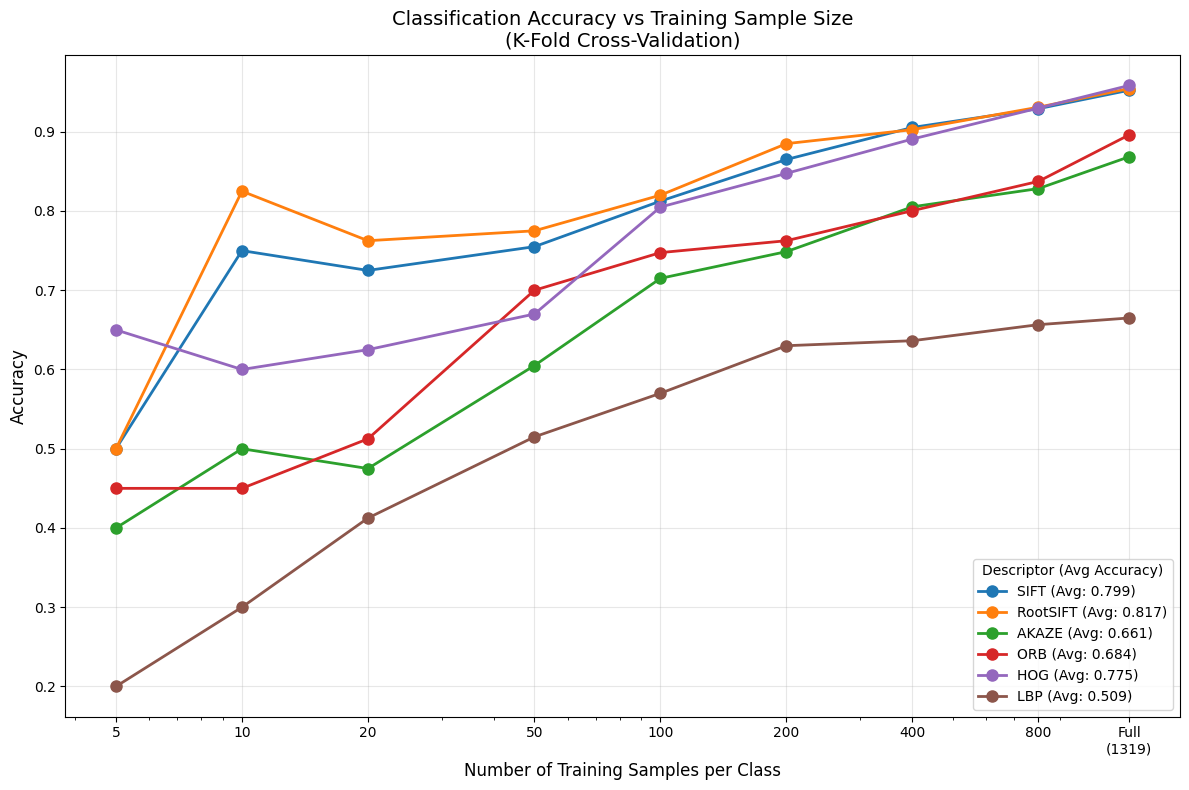

In [53]:
COLORS = {
    'SIFT': '#1f77b4',     
    'RootSIFT': '#ff7f0e',  
    'AKAZE': '#2ca02c',     
    'ORB': '#d62728',     
    'HOG': '#9467bd',       
    'LBP': '#8c564b',       
}

full_samples_per_class = len(all_labels) // NUM_CLASSES
numeric_sample_sizes = [s if s != 'full' else full_samples_per_class for s in SAMPLE_SIZES]

plt.figure(figsize=(12, 8))

for desc_name in DESCRIPTORS.keys():
    means = []
    stds = []
    
    for sample_size in SAMPLE_SIZES:
        res = results[desc_name][sample_size]
        means.append(res['mean_accuracy'])
        stds.append(res['std_accuracy'])
    
    means = np.array(means)
    stds = np.array(stds)
    
    avg_accuracy = np.mean(means)
    
    plt.plot(numeric_sample_sizes, means, 'o-', color=COLORS[desc_name], 
             linewidth=2, markersize=8, 
             label=f'{desc_name} (Avg: {avg_accuracy:.3f})')

plt.xlabel('Number of Training Samples per Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Classification Accuracy vs Training Sample Size\n(K-Fold Cross-Validation)', fontsize=14)
plt.legend(loc='lower right', fontsize=10, title='Descriptor (Avg Accuracy)')
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.xticks(numeric_sample_sizes, [str(s) if s != 'full' else f'Full\n({full_samples_per_class})' for s in SAMPLE_SIZES])

plt.tight_layout()
plt.savefig('accuracy_vs_samples_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()

### Bar Plot: Descriptor Comparison (Mean Accuracy with Standard Deviation)

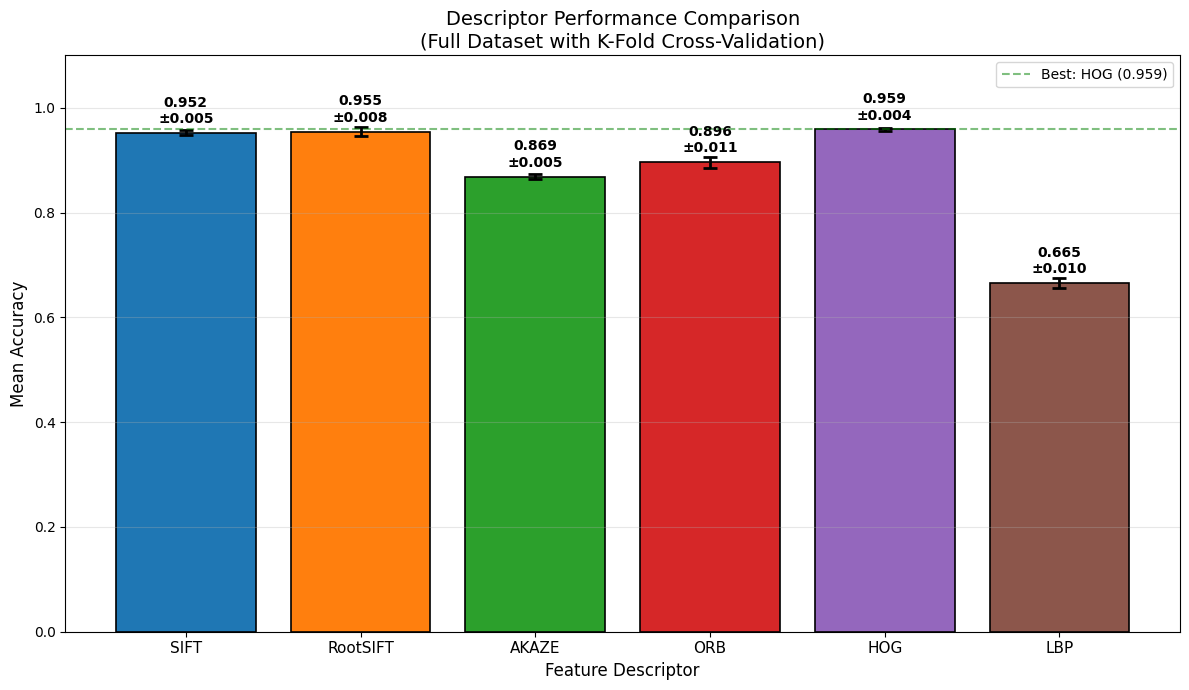

In [54]:
desc_names = list(DESCRIPTORS.keys())
overall_means = []
overall_stds = []

for desc_name in desc_names:
    res = results[desc_name]['full']
    overall_means.append(res['mean_accuracy'])
    overall_stds.append(res['std_accuracy'])

fig, ax = plt.subplots(figsize=(12, 7))

x_pos = np.arange(len(desc_names))
bars = ax.bar(x_pos, overall_means, yerr=overall_stds, 
              color=[COLORS[name] for name in desc_names],
              capsize=5, edgecolor='black', linewidth=1.2,
              error_kw={'elinewidth': 2, 'capthick': 2})

for bar, mean, std in zip(bars, overall_means, overall_stds):
    height = bar.get_height()
    ax.annotate(f'{mean:.3f}\n±{std:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Feature Descriptor', fontsize=12)
ax.set_ylabel('Mean Accuracy', fontsize=12)
ax.set_title('Descriptor Performance Comparison\n(Full Dataset with K-Fold Cross-Validation)', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(desc_names, fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

best_idx = np.argmax(overall_means)
ax.axhline(y=overall_means[best_idx], color='green', linestyle='--', alpha=0.5, 
           label=f'Best: {desc_names[best_idx]} ({overall_means[best_idx]:.3f})')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('descriptor_comparison_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap: Accuracy by Descriptor and Sample Size

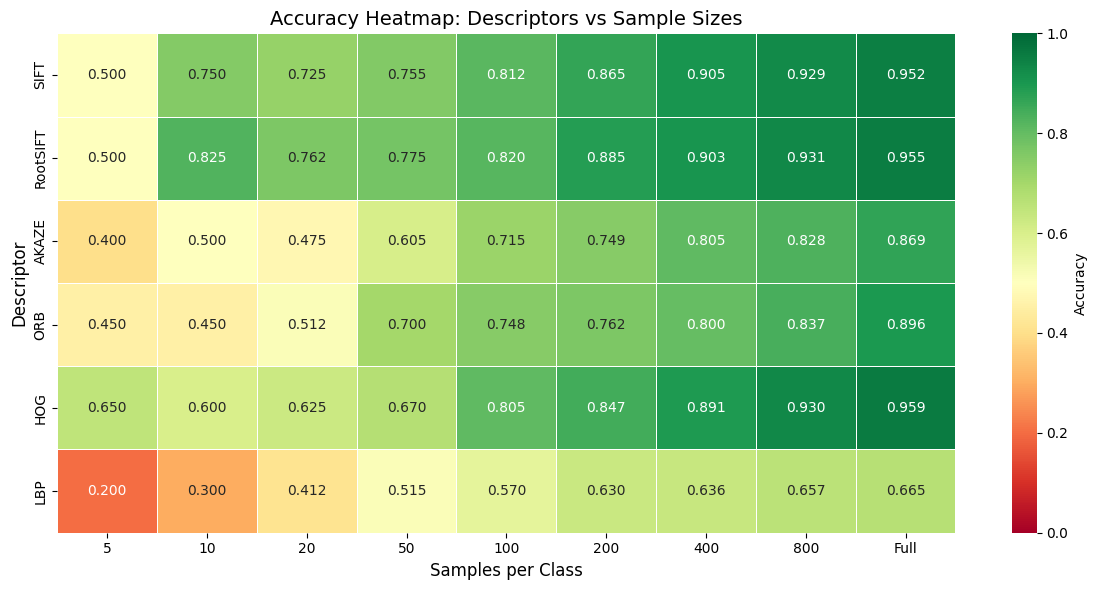

In [55]:
heatmap_data = []
sample_labels = [str(s) if s != 'full' else 'Full' for s in SAMPLE_SIZES]

for desc_name in desc_names:
    row = [results[desc_name][s]['mean_accuracy'] for s in SAMPLE_SIZES]
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=desc_names, columns=sample_labels)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, linewidths=0.5, cbar_kws={'label': 'Accuracy'})
plt.xlabel('Samples per Class', fontsize=12)
plt.ylabel('Descriptor', fontsize=12)
plt.title('Accuracy Heatmap: Descriptors vs Sample Sizes', fontsize=14)
plt.tight_layout()
plt.savefig('accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Best Models and Results

In [56]:
os.makedirs('models', exist_ok=True)

def save_model(name, svc, kmeans=None, results_info=None):
    model_data = {
        'svc': svc,
        'kmeans': kmeans,
        'descriptor_name': name,
        'results': results_info
    }
    filepath = f'models/rps_classifier_{name.lower()}_best.pkl'
    with open(filepath, 'wb') as f:
        pickle.dump(model_data, f)
    print(f"Model saved to '{filepath}'")
    return filepath

saved_models = {}
print("Saving best models (trained on full dataset):\n")

for desc_name in DESCRIPTORS.keys():
    best_model = best_models[desc_name]['full']
    kmeans = DESCRIPTORS[desc_name]['kmeans']
    results_info = results[desc_name]['full']
    
    if best_model is not None:
        filepath = save_model(desc_name, best_model, kmeans, results_info)
        saved_models[desc_name] = filepath
        print(f"  - {desc_name}: Accuracy = {results_info['mean_accuracy']:.4f} ± {results_info['std_accuracy']:.4f}")
    else:
        print(f"  - {desc_name}: No model to save (training failed)")

print(f"\n{len(saved_models)} models saved to 'models/' directory")

Saving best models (trained on full dataset):

Model saved to 'models/rps_classifier_sift_best.pkl'
  - SIFT: Accuracy = 0.9524 ± 0.0052
Model saved to 'models/rps_classifier_rootsift_best.pkl'
  - RootSIFT: Accuracy = 0.9545 ± 0.0081
Model saved to 'models/rps_classifier_akaze_best.pkl'
  - AKAZE: Accuracy = 0.8685 ± 0.0049
Model saved to 'models/rps_classifier_orb_best.pkl'
  - ORB: Accuracy = 0.8962 ± 0.0105
Model saved to 'models/rps_classifier_hog_best.pkl'
  - HOG: Accuracy = 0.9585 ± 0.0036
Model saved to 'models/rps_classifier_lbp_best.pkl'
  - LBP: Accuracy = 0.6650 ± 0.0098

6 models saved to 'models/' directory


In [57]:
def load_model(filename):
    try:
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        
        svc = model_data['svc']
        kmeans = model_data.get('kmeans', None)
        desc_name = model_data.get('descriptor_name', 'Unknown')
        results_info = model_data.get('results', {})
        
        print(f"Loaded model: {desc_name}")
        return svc, kmeans
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

## 8. Classify New Images

In [58]:
def classify_image(image_path, descriptor, kmeans=None, svc=None, local_descriptor=True):
    img = cv2.imread(image_path)
    
    img_resized = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (3, 3), 0)

    if local_descriptor:
        _, desc = descriptor.detectAndCompute(gray_blur, None)
        hist = create_histogram(desc, kmeans, N_CLUSTERS)
    else:
        hist = descriptor.compute(gray_blur)

    probs = svc.predict_proba([hist])[0]
    pred_idx = np.argmax(probs)
    pred_class = CLASSES[pred_idx]
    confidence = probs[pred_idx]

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"{pred_class.upper()} ({confidence:.1%})", fontsize=14)
    plt.axis('off')
    plt.show()
    
    print(f"  Probabilities: ", end="")
    for i, cls in enumerate(CLASSES):
        print(f"{cls}={probs[i]:.1%} ", end="")
    print()

    return pred_class, confidence

In [59]:
svc_sift, kmeans_sift = load_model('models/rps_classifier_sift_best.pkl')
svc_rootsift, kmeans_rootsift = load_model('models/rps_classifier_rootsift_best.pkl')
svc_akaze, kmeans_akaze = load_model('models/rps_classifier_akaze_best.pkl')
svc_orb, kmeans_orb = load_model('models/rps_classifier_orb_best.pkl')
svc_hog, _ = load_model('models/rps_classifier_hog_best.pkl')
svc_lbp, _ = load_model('models/rps_classifier_lbp_best.pkl')

Loaded model: SIFT
Loaded model: RootSIFT
Loaded model: AKAZE
Loaded model: ORB
Loaded model: HOG
Loaded model: LBP


In [60]:
def show_keypoints(path):
    img = cv2.imread(path)

    resized_img = resize_image(img)
    kps, desc = rootsift.detectAndCompute(resized_img, None)

    img_test = cv2.drawKeypoints(resized_img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
    plt.title("SIFT Keypoints with Descriptor Orientation")
    plt.axis('off')
    plt.show()

Testing: IMG20251209122619.jpg


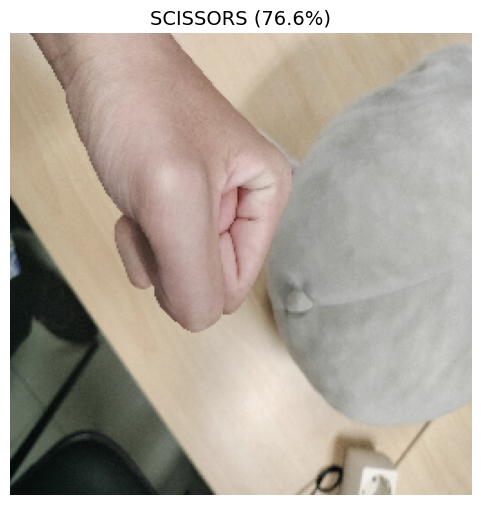

  Probabilities: rock=3.1% scissors=76.6% paper=14.9% background=5.4% 
Testing: IMG20251209122630.jpg


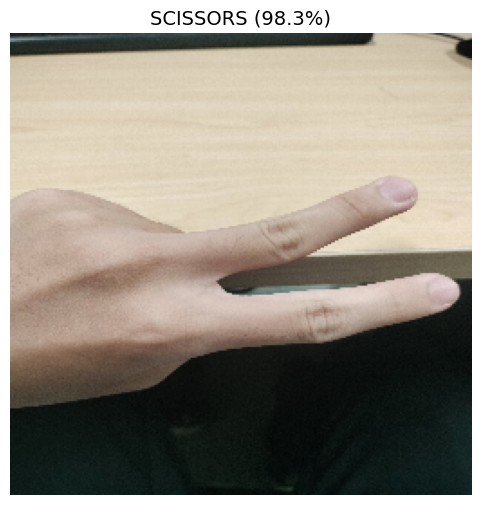

  Probabilities: rock=0.2% scissors=98.3% paper=0.1% background=1.4% 
Testing: IMG20251209122639.jpg


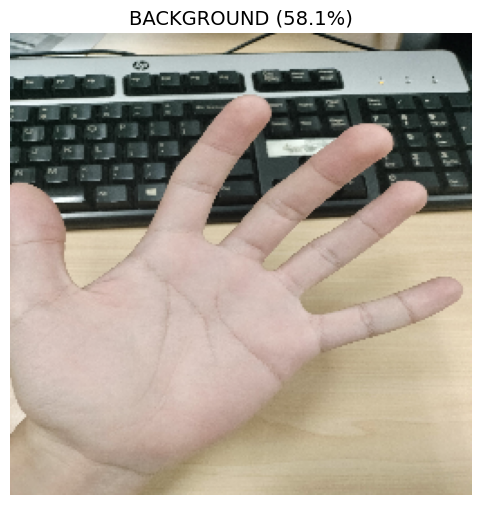

  Probabilities: rock=0.5% scissors=5.0% paper=36.4% background=58.1% 
Testing: IMG20251209124037.jpg


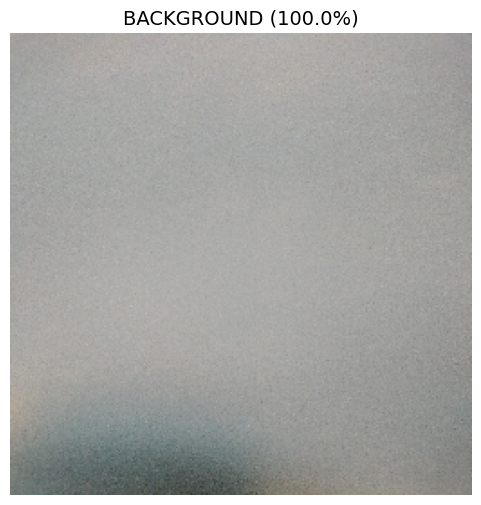

  Probabilities: rock=0.0% scissors=0.0% paper=0.0% background=100.0% 
Testing: IMG20251209124104.jpg


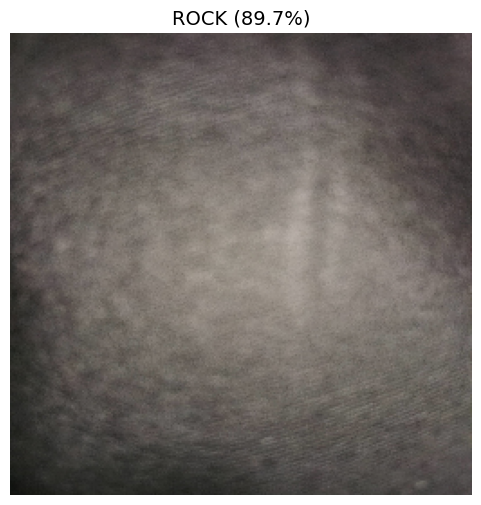

  Probabilities: rock=89.7% scissors=0.0% paper=0.5% background=9.9% 
Testing: IMG20251209124143.jpg


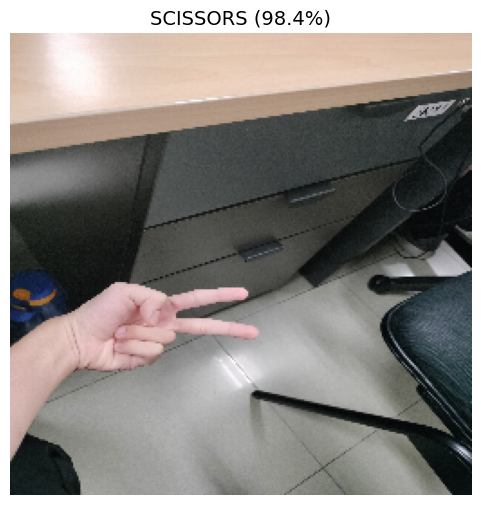

  Probabilities: rock=0.7% scissors=98.4% paper=0.4% background=0.6% 
Testing: IMG20251210152813.jpg


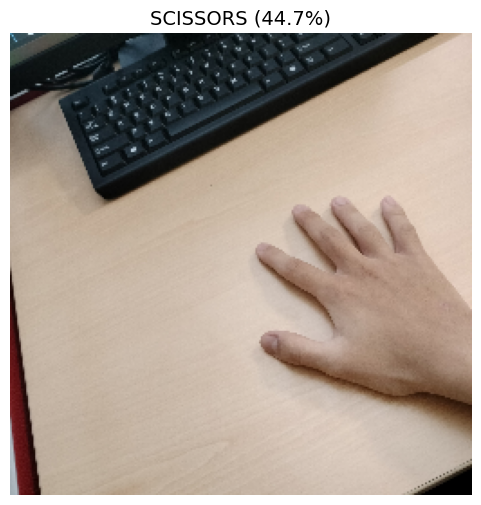

  Probabilities: rock=30.5% scissors=44.7% paper=14.2% background=10.6% 
Testing: IMG20251210152832.jpg


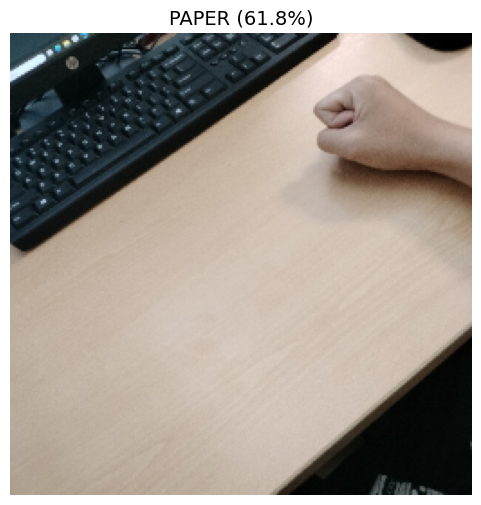

  Probabilities: rock=31.4% scissors=3.3% paper=61.8% background=3.5% 
Testing: IMG20251210152836.jpg


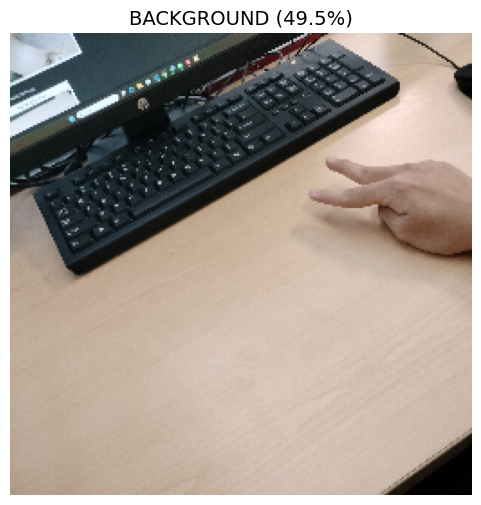

  Probabilities: rock=10.9% scissors=1.1% paper=38.6% background=49.5% 
Testing: IMG20251210152858.jpg


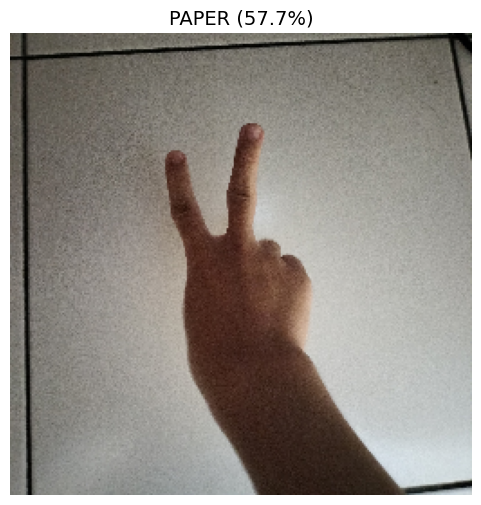

  Probabilities: rock=1.5% scissors=15.4% paper=57.7% background=25.4% 
Testing: IMG_20251208_083311.jpg


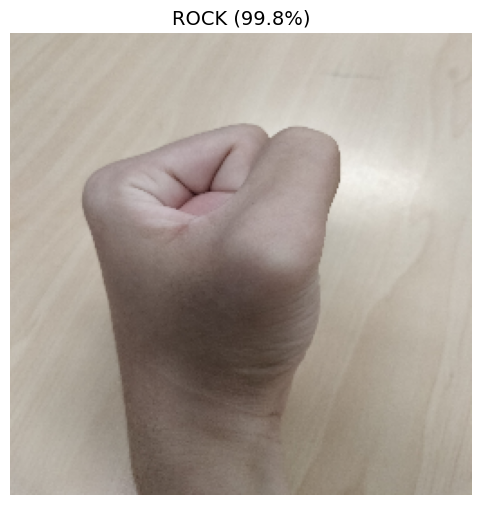

  Probabilities: rock=99.8% scissors=0.1% paper=0.1% background=0.0% 


In [61]:
test_path = './test_images/'

for f in os.listdir(test_path):

  print(f"Testing: {f}")
  # show_keypoints(os.path.join(test_path, f))
  # classify_image(os.path.join(test_path, f), descriptor=orb, kmeans=kmeans_orb, svc=svc_orb)
  classify_image(os.path.join(test_path, f), descriptor=hog_desc, svc=svc_hog, local_descriptor=False)

## Summary

### Pipeline
**Image → Feature Extraction → BoVW Histogram (for keypoint descriptors) → SVM → Classification**

### Evaluation Methodology
- **K-Fold Cross-Validation**: 5 folds for robust performance estimation
- **Sample Sizes**: 1, 5, 10, 20, 50, 100, and full dataset per class
- **Metrics**: Mean accuracy ± standard deviation

### Feature Descriptors Evaluated
| Descriptor | Type | Description |
|------------|------|-------------|
| SIFT | Keypoint | Scale-Invariant Feature Transform |
| RootSIFT | Keypoint | L1-normalized SIFT with square root |
| AKAZE | Keypoint | Accelerated-KAZE features |
| ORB | Keypoint | Oriented FAST and Rotated BRIEF |
| HOG | Global | Histogram of Oriented Gradients |
| LBP | Global | Local Binary Patterns |

### Output Files
- `accuracy_vs_samples_lineplot.png` - Line plot of accuracy vs sample size
- `descriptor_comparison_barplot.png` - Bar plot comparing descriptors
- `accuracy_heatmap.png` - Heatmap of accuracy by descriptor and sample size
- `cross_validation_results.csv` - Detailed results in CSV format
- `models/*.pkl` - Trained models for each descriptor

### Usage
```python
# Load a trained model
svc, kmeans = load_model('models/rps_classifier_akaze_best.pkl')

# Classify an image
pred_class, confidence = classify_image('path/to/image.jpg', akaze, kmeans, svc)
```